In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

from matplotlib import pyplot

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [3]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [4]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

## XGBoost Without PCA and without Feature Engineering


In [18]:
files = ['CompleteWeeklyIndexes', 'MeanWeeklyImputed', 'KNNWeeklyImputed', 'MovingAverageWeeklyImputed', 'RegressionWeeklyImputed', 'MIIWeeklyImputed']

for file in files:
    if "Complete" in file:
        df = read_csv(file+'.csv')
        print(file)
        X_test = df.loc['2015-01-02':]
        df.fillna(0)
        X_test.fillna(0)
        
    else:
        df = read_csv(file+'_training.csv')
        print(file)
        X_test = read_csv(file + '_test.csv')
    
    
    
    y = pd.read_csv('sp500_target_regimes.csv', parse_dates=True)
    y.index = y['date'].values
    y = y[['regime']]
    y = y['regime']=='BEAR'
    y = pd.DataFrame (y, columns = ['regime'])
       

    X_train = df.loc['2000-01-01':'2015-01-01']
    X_test = X_test.loc['2015-01-02':]
    y_train = y.loc['2000-01-01':'2015-01-01']
    y_test = y.loc['2015-01-02':]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    param_test1 = {
        'learning_rate':[0.01, 0.1],
        'n_estimators':[500, 1000],
        'max_depth':range(2,6,1),
        'subsample':np.arange(0.8,1,0.1),
        'min_child_weight':range(1,6,2),
        'colsample_bytree':np.arange(0.3,1,0.2),
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic",
                                                          disable_default_eval_metric = 1,
                                                          learning_rate=0.01, 
                                                          n_estimators=100, 
                                                          random_state=27, 
                                                          min_child_weight=1, 
                                                          gamma=1, 
                                                          max_depth=2,
                                                          subsample=0.8,
                                                          colsample_bytree=0.3,
                                                          ), 
                            param_grid = param_test1, 
                            scoring='f1',
                            n_jobs=4,
                            iid=False, 
                            cv=tscv)

    gsearch1.fit(X_train, y_train, eval_metric=f1_eval)
    print(gsearch1.best_params_, gsearch1.best_score_)
    
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                  disable_default_eval_metric = 1,
                                  learning_rate=gsearch1.best_params_['learning_rate'], 
                                  n_estimators=gsearch1.best_params_['n_estimators'], 
                                  random_state=27, 
                                  min_child_weight=gsearch1.best_params_['min_child_weight'], 
                                  gamma=1, 
                                  max_depth=gsearch1.best_params_['max_depth'],
                                  subsample=gsearch1.best_params_['subsample'],
                                  colsample_bytree=gsearch1.best_params_['colsample_bytree'],
                                  )

    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=f1_eval, verbose=False)

    y_train_pred = xgb_model.predict(X_train)
    print("_______________________________________")
    print("______________Training_________________")
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*precision*recall/(precision+recall)  
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("F1 score", 1-f_score)
    print("---------------------------------------")
    print("_______________Testing_________________")
    y_pred = xgb_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*precision*recall/(precision+recall)  
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("F1 score", 1-f_score)
    print("---------------------------------------")


CompleteWeeklyIndexes
(782, 22) (782, 1) (272, 22) (272, 1)
{'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.9} 0.3610259269584611
_______________________________________
______________Training_________________
     True False
True    368    0
False   4    410
_______________________________________
F1 score 0.00540540540540535
---------------------------------------
_______________Testing_________________
     True False
True    24    7
False   41    200
_______________________________________
F1 score 0.5
---------------------------------------
MeanWeeklyImputed
(782, 22) (782, 1) (272, 22) (272, 1)
{'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8} 0.500723333686179
_______________________________________
______________Training_________________
     True False
True    356    6
False   16    404
__________

In [5]:
best_params = {
    'CompleteWeeklyIndexes': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.9},
    'MeanWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8},
    'KNNWeeklyImputed': {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9},
    'MovingAverageWeeklyImputed': {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 1000, 'subsample': 0.9},
    'RegressionWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8},
    'MIIWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
}

files = ['CompleteWeeklyIndexes', 'MeanWeeklyImputed', 'KNNWeeklyImputed', 'MovingAverageWeeklyImputed', 'RegressionWeeklyImputed', 'MIIWeeklyImputed']

In [35]:
def run_experiment_multiple_times(best_params, files, n=30):
    result_dict = {}
    for file in files:
        print(file)
        result_dict[file] = {'f1':0, 'tn':0, 'fp':0, 'fn':0, 'tp':0}
        for i in range(0,n):
            if "Complete" in file:
                df = read_csv(file+'.csv')
                X_test = df.loc['2015-01-02':]
                df.fillna(0)
                X_test.fillna(0)

            else:
                df = read_csv(file+'_training.csv')
                X_test = read_csv(file + '_test.csv')


            y = pd.read_csv('sp500_target_regimes.csv', parse_dates=True)
            y.index = y['date'].values
            y = y[['regime']]
            y = y['regime']=='BEAR'
            y = pd.DataFrame (y, columns = ['regime'])


            X_train = df.loc['2000-01-01':'2015-01-01']
            X_test = X_test.loc['2015-01-02':]
            y_train = y.loc['2000-01-01':'2015-01-01']
            y_test = y.loc['2015-01-02':]
            
            xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                  disable_default_eval_metric = 1,
                                  learning_rate=best_params[file]['learning_rate'], 
                                  n_estimators=best_params[file]['n_estimators'], 
                                  min_child_weight=best_params[file]['min_child_weight'], 
                                  gamma=1, 
                                  max_depth=best_params[file]['max_depth'],
                                  subsample=best_params[file]['subsample'],
                                  colsample_bytree=best_params[file]['colsample_bytree'],
                                  )

            b = xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=f1_eval, verbose=False)
            y_pred = xgb_model.predict(X_test)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
            f_score = 1-(2*precision*recall/(precision+recall))
            result_dict[file]['f1'] += f_score
            result_dict[file]['tn'] += tn
            result_dict[file]['fp'] += fp
            result_dict[file]['fn'] += fn
            result_dict[file]['tp'] += tp
        
        # feature importance
        data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
        data.plot(kind='barh', title=file, figsize=(10,10))
        
        result_dict[file]['f1'] = result_dict[file]['f1']/n
        result_dict[file]['tn'] = result_dict[file]['tn']/n
        result_dict[file]['fp'] = result_dict[file]['fp']/n
        result_dict[file]['fn'] = result_dict[file]['fn']/n
        result_dict[file]['tp'] = result_dict[file]['tp']/n
        
    return result_dict     

CompleteWeeklyIndexes
MeanWeeklyImputed
KNNWeeklyImputed
MovingAverageWeeklyImputed
RegressionWeeklyImputed
MIIWeeklyImputed


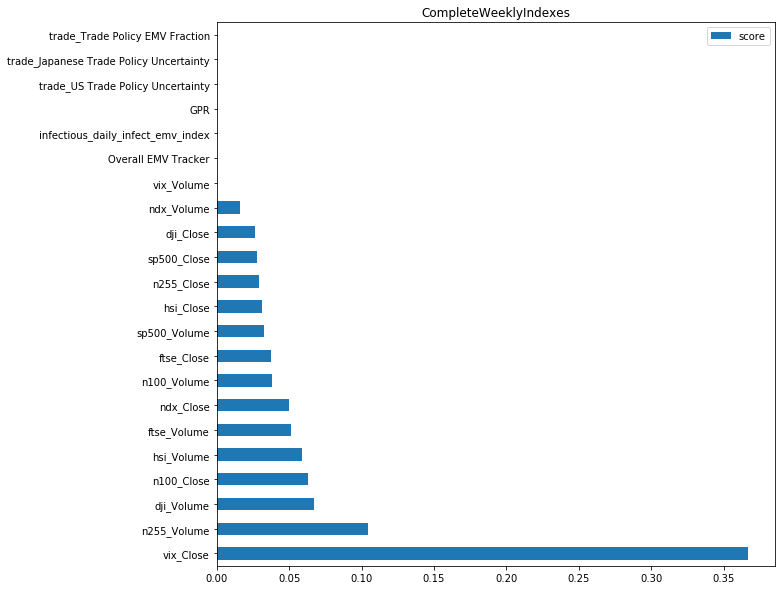

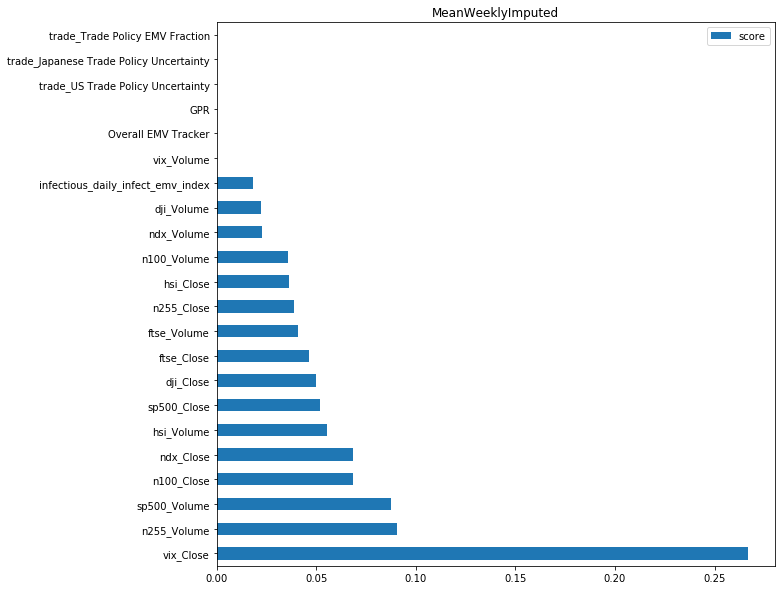

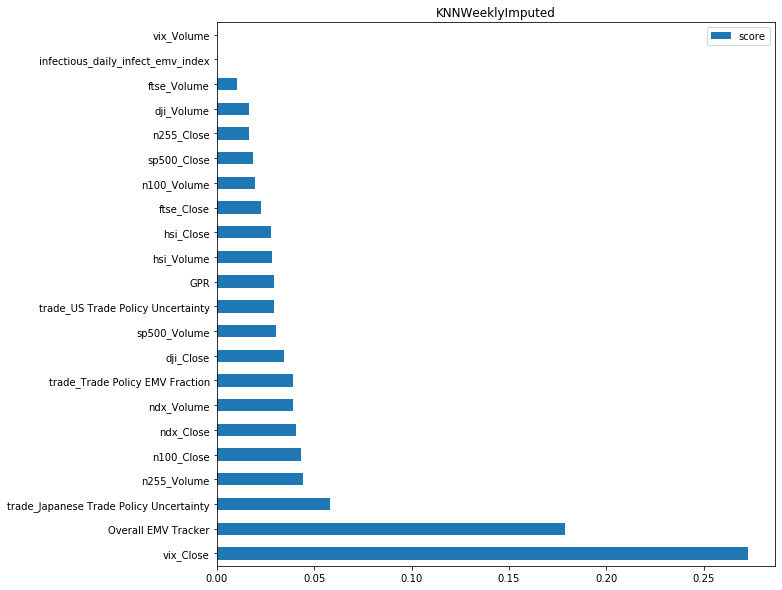

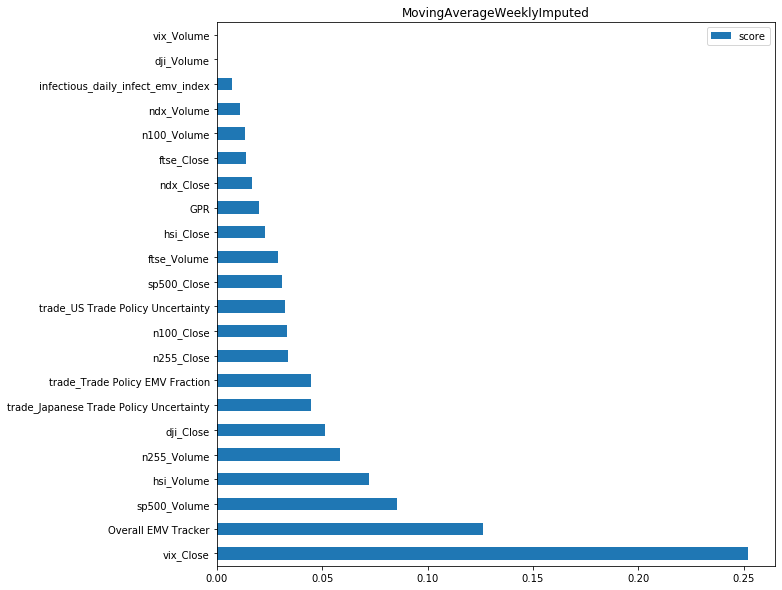

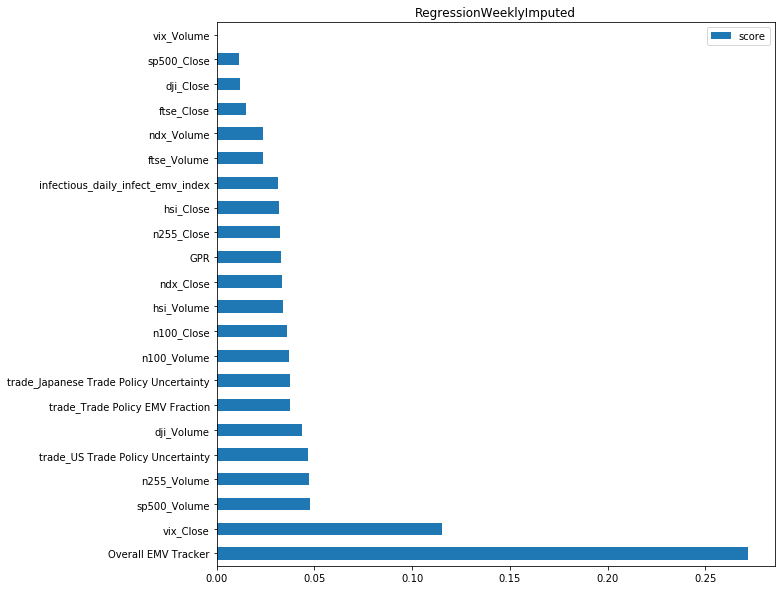

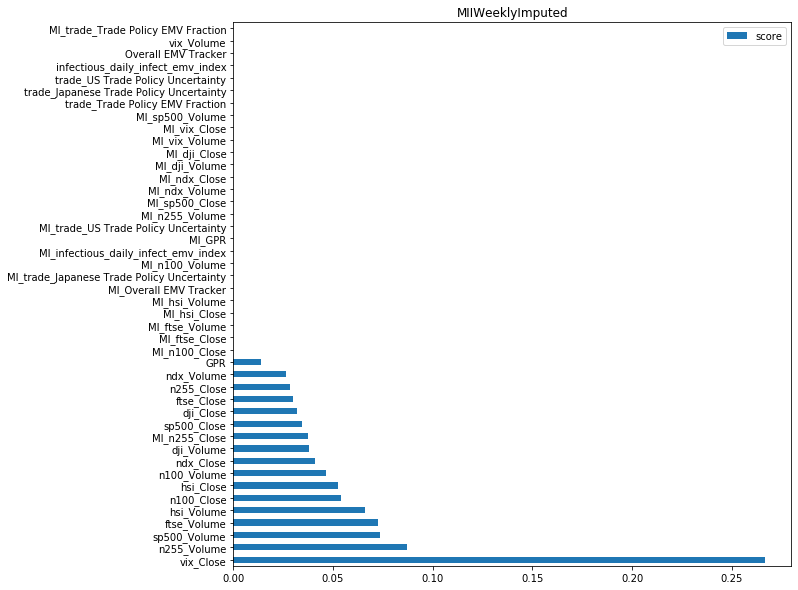

In [37]:
result_dict = run_experiment_multiple_times(best_params, files, n=30)

In [38]:
result_dict

{'CompleteWeeklyIndexes': {'f1': 0.42,
  'tn': 201.0,
  'fp': 6.0,
  'fn': 36.0,
  'tp': 29.0},
 'MeanWeeklyImputed': {'f1': 0.3577981651376146,
  'tn': 198.0,
  'fp': 9.0,
  'fn': 30.0,
  'tp': 35.0},
 'KNNWeeklyImputed': {'f1': 0.46808510638297907,
  'tn': 203.0,
  'fp': 4.0,
  'fn': 40.0,
  'tp': 25.0},
 'MovingAverageWeeklyImputed': {'f1': nan,
  'tn': 207.0,
  'fp': 0.0,
  'fn': 65.0,
  'tp': 0.0},
 'RegressionWeeklyImputed': {'f1': 0.7402597402597403,
  'tn': 205.0,
  'fp': 2.0,
  'fn': 55.0,
  'tp': 10.0},
 'MIIWeeklyImputed': {'f1': 0.3653846153846155,
  'tn': 201.0,
  'fp': 6.0,
  'fn': 32.0,
  'tp': 33.0}}

In [39]:
for key, item in result_dict.items():
    print(key)
    print("F1_score", item['f1'])
    print_confusion_matrix(item['tn'], item['fp'], item['fn'], item['tp'])
    print("_______________________________________________________________________________")

CompleteWeeklyIndexes
F1_score 0.42
     True False
True    29.0    6.0
False   36.0    201.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
MeanWeeklyImputed
F1_score 0.3577981651376146
     True False
True    35.0    9.0
False   30.0    198.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
KNNWeeklyImputed
F1_score 0.46808510638297907
     True False
True    25.0    4.0
False   40.0    203.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
MovingAverageWeeklyImputed
F1_score nan
     True False
True    0.0    0.0
False   65.0    207.0
_______________________________________
---------------------------------------
_________________________________________